In [596]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# jax
import jax.numpy as jnp
from jax import random
import time

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

# interpolation
from scipy.interpolate import CubicSpline

# pre-processing
from sklearn.preprocessing import StandardScaler

# collocation
import sys
import os

collocation2_path = os.path.abspath(os.path.join('..', '00_utils'))
if collocation2_path not in sys.path:
    sys.path.append(collocation2_path)

from collocation import compute_weights, lagrange_derivative
from non_parametric_collocation import collocate_data

import statsmodels.api as sm
from scipy.ndimage import gaussian_filter1d
from data_generation import generate_ode_data

collocation_path = os.path.abspath(os.path.join('..', '04_energy_consumption_reformat'))

if collocation_path not in sys.path:
    sys.path.append(collocation_path)
    
import nn_pyomo

In [2]:
# pyomo
import importlib
import nn_pyomo_admm_2

importlib.reload(nn_pyomo_admm_2)
NeuralODEPyomoADMM = nn_pyomo_admm_2.NeuralODEPyomoADMM

### Prepare data for decomposition
* Starting with the toy dataset to ensure the approach works

In [3]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 400
noise_level = 0.2
ode_type, params = "harmonic_oscillator", {"omega_squared": 2}
start_time, end_time = 0, 10*2
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_ho_cheb, y_ho_cheb, y_noisy_ho_cheb, true_derivatives_ho_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_ho_cheb = np.array(jnp.squeeze(y_noisy_ho_cheb))
t_ho_cheb = np.array(jnp.squeeze(t_ho_cheb))

In [4]:
decomposition = False
#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
if decomposition:
    weights_ho_cheb = compute_weights(t_ho_cheb[:int(N/2)])
    D_ho_cheb = np.array(lagrange_derivative(t_ho_cheb[:int(N/2)], weights_ho_cheb))
else: 
    weights_ho_cheb = compute_weights(t_ho_cheb)
    D_ho_cheb = np.array(lagrange_derivative(t_ho_cheb, weights_ho_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_ho_cheb, y_test_ho_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, 20, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_ho_cheb, estimated_solution_ho_cheb = collocate_data(y_noisy_ho_cheb, t_ho_cheb, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [5]:
L = 0
R = 200

importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo

# prepare data
ys = np.atleast_2d(y_noisy_ho_cheb[L:R, 0]).T
ts = np.array(t_ho_cheb)[L:R]
Xs = np.atleast_2d(y_noisy_ho_cheb[L:R, 1]).T
Ds = np.array(D_ho_cheb)[L:R, L:R]

layer_widths = [2, 20, 1]

# solver.options['print_level'] = 5
tol = 1e-7
params = {"tol":1e-7, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        
        # repeat the same for the acceptable tolerances
        "acceptable_tol": 1e-15, "acceptable_constr_viol_tol": 1e-15, "acceptable_dual_inf_tol": 1e-15, "acceptable_compl_inf_tol": 1e-15, "acceptable_iter": 0, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, 
        #"hessian_approximation": 'limited-memory', 
        #"mu_strategy": 'adaptive', #"check_derivatives_for_naninf": 'yes',
        #'nlp_scaling_method' = 'gradient-based', # 'linear_solver'] = 'ma57',
        "max_iter": 1000}

# ----------------------------------------------------------- #
ode_model = NeuralODEPyomo(np.array(ys), # y
                        np.array(ts), # t
                        np.array(Ds),
                        
                        layer_widths, act_func = "tanh", 
                        y_init = ys, 
                        penalty_lambda_reg = 0.1, 
                        time_invariant = True,
                        extra_input = Xs, # X
                        w_init_method = 'xavier', 
                        params = params,
                        deriv_method="collocation",
                        penalty_lambda_smooth = 0.0,
                        ncp = 3
                        #discretization_scheme = "LAGRANGE-LEGENDRE",
                        )

ode_model.build_model()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    55919
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    16321

Total number of variables............................:      281
             

Mean Absolute Error - Direct: 0.171337533353935
Mean Absolute Error - ODE solver: 0.1681447786162353


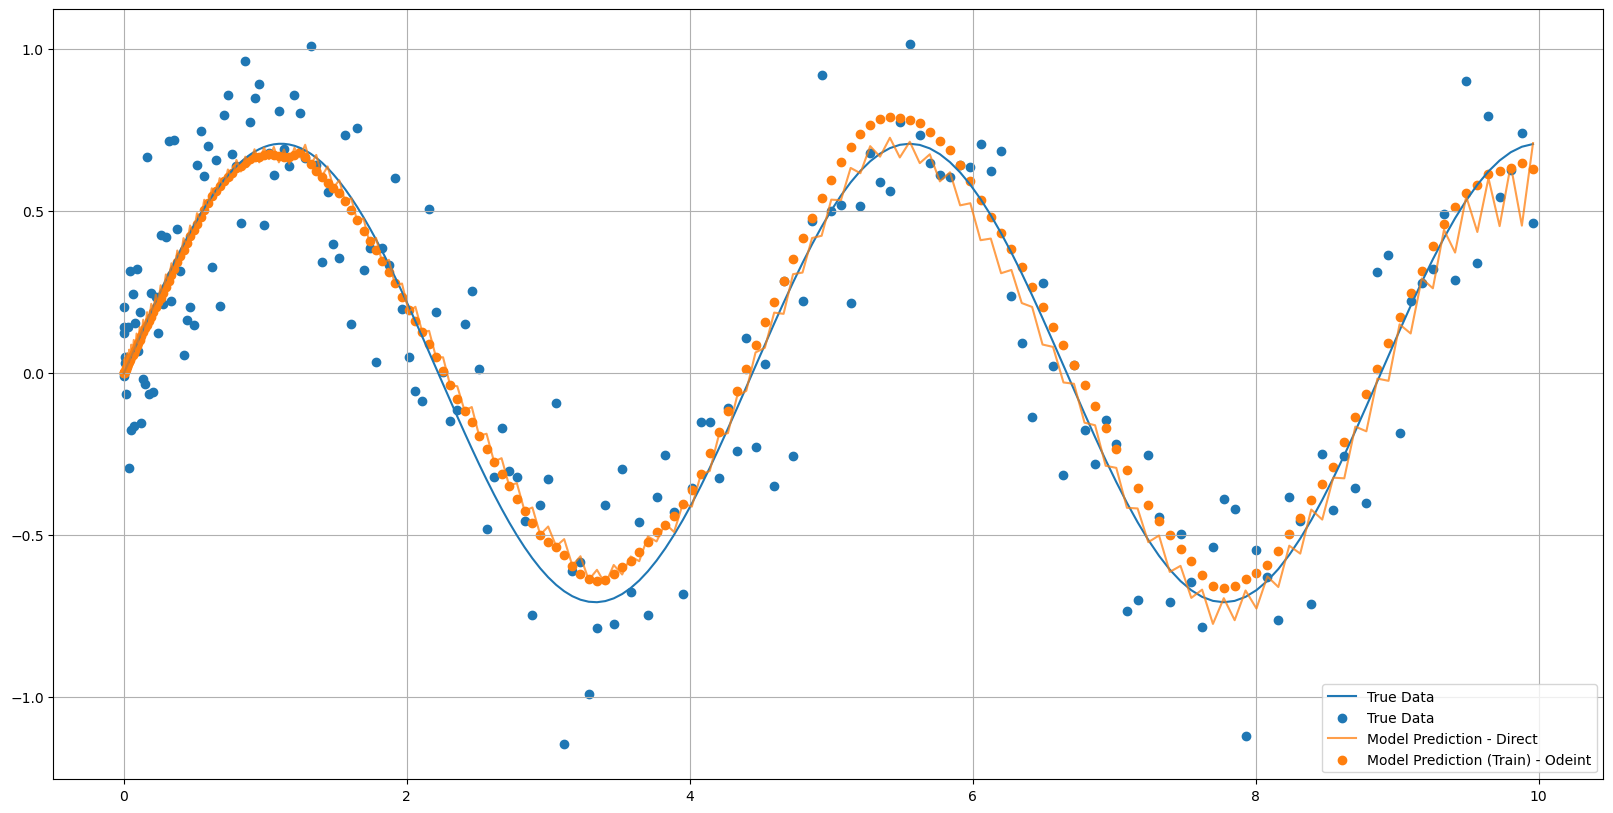

In [6]:
y0 = np.array([0.0])
t = np.array(t_ho_cheb[L:R])
y_pred = ode_model.neural_ode(y0, t, (Xs, t))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

#y0_test = y_test_scaled[0]
#y_pred_test = ode_model.neural_ode(y0_test, ts_test, (Xs_test, ts_test))

plt.figure(figsize=(20, 10))
plt.plot(t_ho_cheb[L:R], y_ho_cheb[L:R,0], label='True Data', alpha = 1)
plt.scatter(t_ho_cheb[L:R], y_noisy_ho_cheb[L:R, 0], label='True Data', alpha = 1)

plt.plot(t_ho_cheb[L:R], u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(t_ho_cheb[L:R], y_pred[:,0], label='Model Prediction (Train) - Odeint')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

We are considering problem decomposition for a task that requires Chebyshev node, spacing; </br>
The nodes have to be regenerated between the batches, because splitting half way does not produce good results

---

## Van Der Pol

In [7]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp_cheb, y_vdp_cheb, y_noisy_vdp_cheb, true_derivatives_vdp_cheb = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time*2, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp_cheb = np.array(jnp.squeeze(y_noisy_vdp_cheb))
t_vdp_cheb = np.array(jnp.squeeze(t_vdp_cheb))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_vdp_cheb = compute_weights(t_vdp_cheb)
D_vdp_cheb = np.array(lagrange_derivative(t_vdp_cheb, weights_vdp_cheb))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp_cheb, y_test_vdp_cheb, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
estimated_derivative_vdp_cheb, estimated_solution_vdp_cheb = collocate_data(y_noisy_vdp_cheb, t_vdp_cheb, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [8]:
L, R = 0, 100

importlib.reload(nn_pyomo)
NeuralODEPyomo = nn_pyomo.NeuralODEPyomo

# prepare data
ys = np.atleast_2d(y_noisy_vdp_cheb[L:R,0]).T
ts = np.array(t_vdp_cheb)[L:R]
Xs = np.atleast_2d(y_noisy_vdp_cheb[L:R,1]).T
Ds = np.array(D_vdp_cheb)[L:R, L:R]

layer_widths = [2, 20, 1]

# solver.options['print_level'] = 5
tol = 1e-7
params = {"tol":1e-7, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "acceptable_tol": 1e-15, "acceptable_constr_viol_tol": 1e-15, "acceptable_dual_inf_tol": 1e-15, "acceptable_compl_inf_tol": 1e-15, "acceptable_iter": 0, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 1000}

# ----------------------------------------------------------- #
ode_model = NeuralODEPyomo(
                        np.array(ys), # y
                        np.array(ts), # t
                        np.array(Ds),
                        
                        layer_widths, act_func = "tanh", 
                        y_init = np.array(estimated_solution_vdp_cheb[0]), 
                        penalty_lambda_reg = 0.1, 
                        time_invariant = True,
                        extra_input = Xs, 
                        w_init_method = 'xavier', 
                        params = params,
                        deriv_method="collocation",
                        penalty_lambda_smooth = 0.0,
                        ncp = 3
                        #discretization_scheme = "LAGRANGE-LEGENDRE",
                        )

ode_model.build_model()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    17919
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     8221

Total number of variables............................:      181
             

Mean Absolute Error - Direct: 0.13575988393889912
Mean Absolute Error - ODE solver: 0.10622176356052478


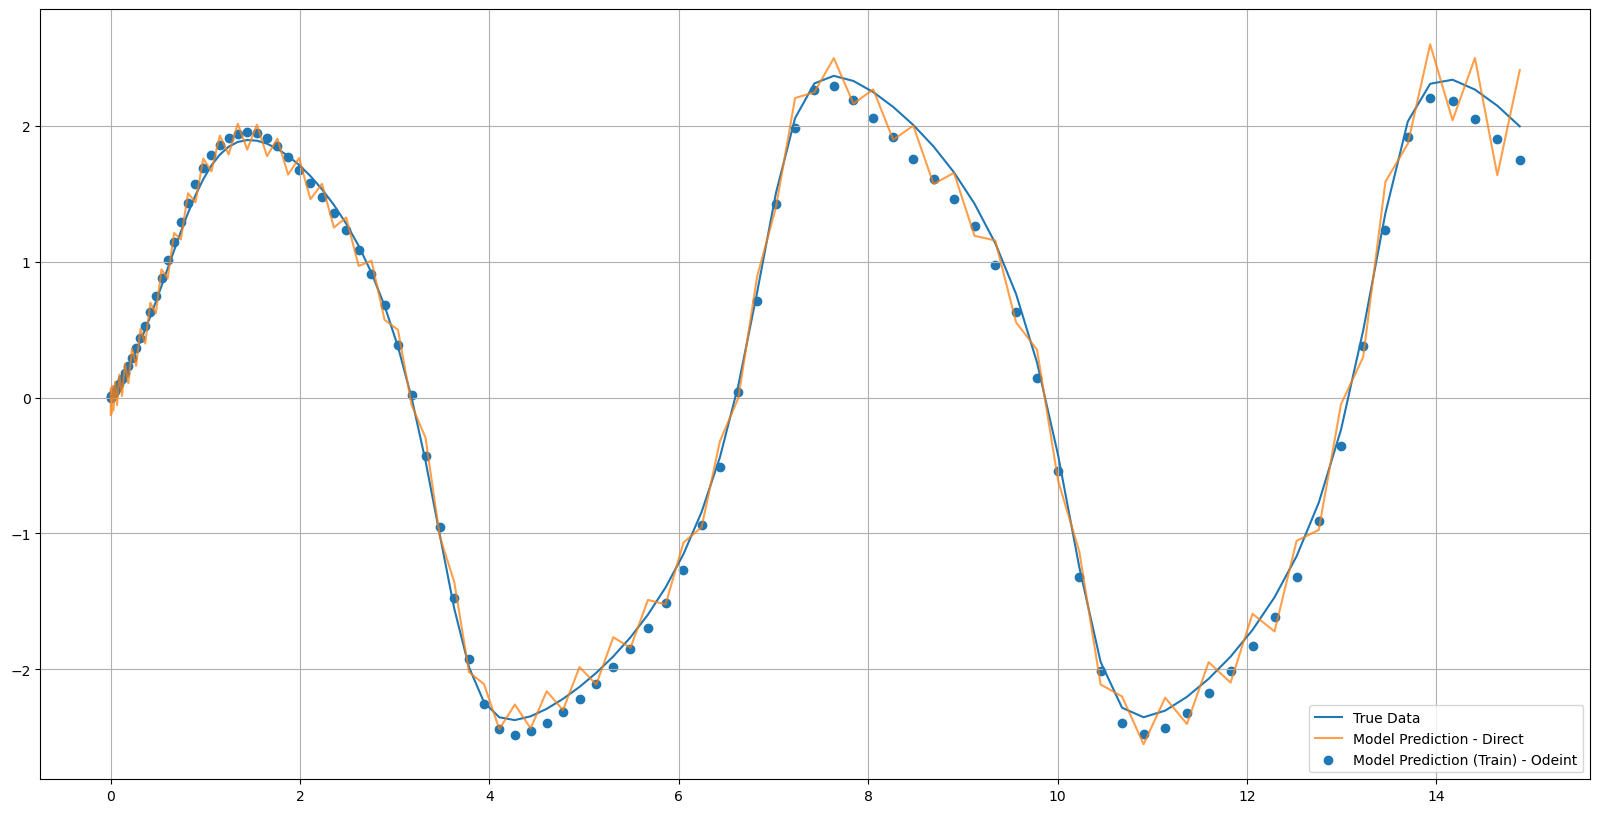

In [9]:
y0 = np.array([0.0])
t = np.array(t_vdp_cheb[L:R])
y_pred = ode_model.neural_ode(y0, t, (Xs, t))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

#y0_test = y_test_scaled[0]
#y_pred_test = ode_model.neural_ode(y0_test, ts_test, (Xs_test, ts_test))

plt.figure(figsize=(20, 10))
plt.plot(t_vdp_cheb[L:R], y_vdp_cheb[L:R,0:1], label='True Data', alpha = 1)
#plt.scatter(t_ho_cheb[L:R], y_noisy_ho_cheb[L:R, 0], label='True Data', alpha = 1)

plt.plot(t_vdp_cheb[L:R], u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(t_vdp_cheb[L:R], y_pred[:,0], label='Model Prediction (Train) - Odeint')

plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

* The quality of the solutions deteriorates when the node spacing does not follow Chebyshev nodes;
* Hence, the points will have to be regenerated when conducting decomposition;

Original data points: 100
New data points: 289


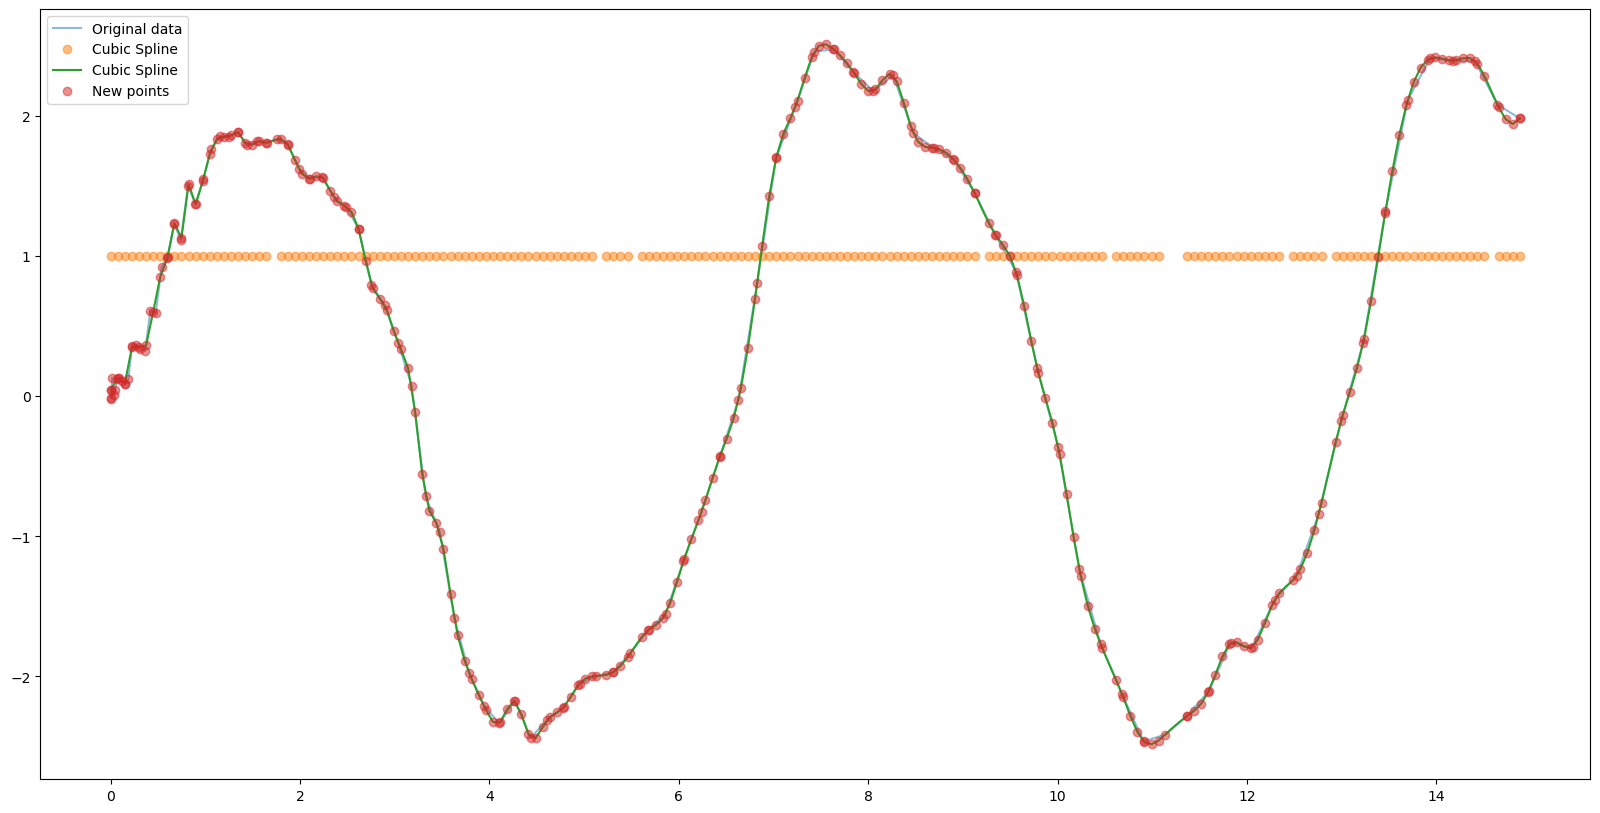

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.ndimage import gaussian_filter1d

ys_smooth = gaussian_filter1d(ys, sigma = 5000)

cs_smooth = CubicSpline(ts, ys_smooth)

def second_derivative(cs, ts):
    return cs(ts, 2)

# Evaluate the second derivative at a fine grid
x_fine = np.linspace(0, max(ts), 200)
second_deriv = second_derivative(cs_smooth, x_fine)

# Threshold for high second derivative
threshold = 0.8

# Identify regions with high second derivative
high_deriv_indices = np.where(np.abs(second_deriv) > threshold)[0]
high_deriv_x = x_fine[high_deriv_indices]

x_new = np.sort(np.concatenate((ts, high_deriv_x)))

cs = CubicSpline(ts, ys)
y_new = cs(x_new)

print(f"Original data points: {len(ts)}")
print(f"New data points: {len(x_new)}")

plt.figure(figsize=(20, 10))
plt.plot(ts, ys, label='Original data', alpha = 0.5)
plt.plot(high_deriv_x, np.ones_like(high_deriv_x), 'o',label='Cubic Spline', alpha = 0.5)
plt.plot(x_fine, cs_smooth(x_fine), label='Cubic Spline')
plt.plot(x_new, y_new, 'o', label='New points', alpha = 0.5)
plt.legend()
plt.show()

* Since Chebyshev Node regeneration as a part of a Pyomo model set up involves extra step, <br>
the initial iteration will look at using the `dae` library to obtain the proof of concept;

#### `1)` Regenerate data but equally spaced

In [11]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 800
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "equally_spaced" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp, y_vdp, y_noisy_vdp, true_derivatives_vdp = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time*2, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp = np.array(jnp.squeeze(y_noisy_vdp))
t_vdp = np.array(jnp.squeeze(t_vdp))

#---------------------------------------------------TEST DATA--------------------------------------------#
t_test_vdp, y_test_vdp, _, _ = generate_ode_data(N*2, noise_level, ode_type, params, start_time, end_time*2, "uniform", initial_state)

estimated_derivative_vdp, estimated_solution_vdp = collocate_data(y_noisy_vdp, t_vdp, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [12]:
#weights_vdp_cheb = compute_weights(t_vdp[400:800])
#D_vdp_cheb = np.array(lagrange_derivative(t_vdp[400:800], weights_vdp_cheb))

* Is the first derivative matrix shared?
* `D (L)` is the derivative matrix of Lagrange polynomials evaluated at
the collocation points

In [13]:
L, R = 0, 200

import nn_pyomo_dae
importlib.reload(nn_pyomo_dae)
NeuralODEPyomo = nn_pyomo_dae.NeuralODEPyomo

# prepare data
ys = np.atleast_2d(y_noisy_vdp[L:R, 0]).T
ts = np.array(t_vdp)[L:R]
Xs = np.atleast_2d(y_noisy_vdp[L:R, 1]).T

layer_widths = [2, 20, 1]

tol = 1e-7
params = {"tol":1e-7, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "acceptable_tol": 1e-15, "acceptable_constr_viol_tol": 1e-15, "acceptable_dual_inf_tol": 1e-15, "acceptable_compl_inf_tol": 1e-15, "acceptable_iter": 0, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 1000}

# ----------------------------------------------------------- #
ode_model = NeuralODEPyomo(
                        np.array(ys), # y 
                        np.array(ts), # t
                        np.array(None), # D
                        
                        layer_widths, act_func = "tanh", 
                        # y_init = np.array(estimated_solution_vdp[0]), 
                        # check what happens when y is not pre-initialized
                        y_init = ys,
                        penalty_lambda_reg = 1, 
                        time_invariant = True,
                        extra_input = Xs, 
                        w_init_method = 'xavier', 
                        params = params,
                        deriv_method="pyomo",
                        penalty_lambda_smooth = 0.0,
                        ncp = 3
                        )

ode_model.build_model()
result = ode_model.solve_model()
u_model = ode_model.extract_solution().T

y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts))

Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
acceptable_tol=1e-15
acceptable_constr_viol_tol=1e-15
acceptable_dual_inf_tol=1e-15
acceptable_compl_inf_tol=1e-15
acceptable_iter=0
halt_on_ampl_error=yes
print_level=5
max_iter=1000


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    52536
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:    48559

Total number of variables............................:     1276
             

In [14]:
derivative =[]
for row in y_noisy_vdp[L:R]:
    derivative.append(ode_model.predict(row))

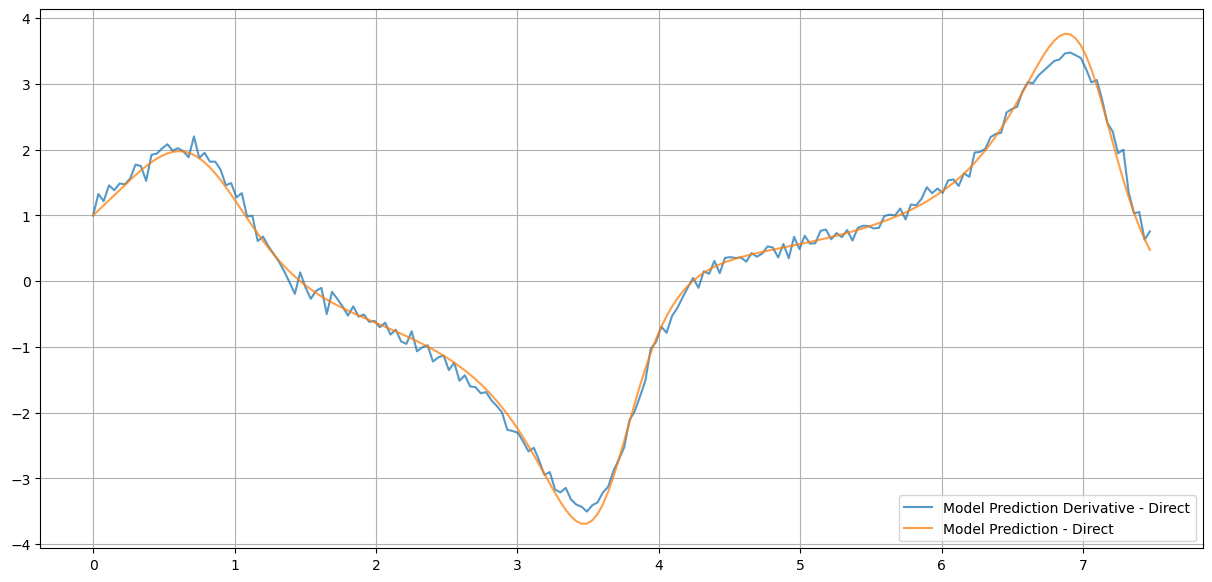

In [15]:
plt.figure(figsize=(15, 7))
plt.plot(t_vdp[L:R], derivative, label='Model Prediction Derivative - Direct', alpha = 0.75)
plt.plot(t_vdp[L:R], true_derivatives_vdp[L:R,0], label='Model Prediction - Direct', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

Mean Absolute Error - Direct: 0.07747114669218638
Mean Absolute Error - ODE solver: 0.08074270323295256


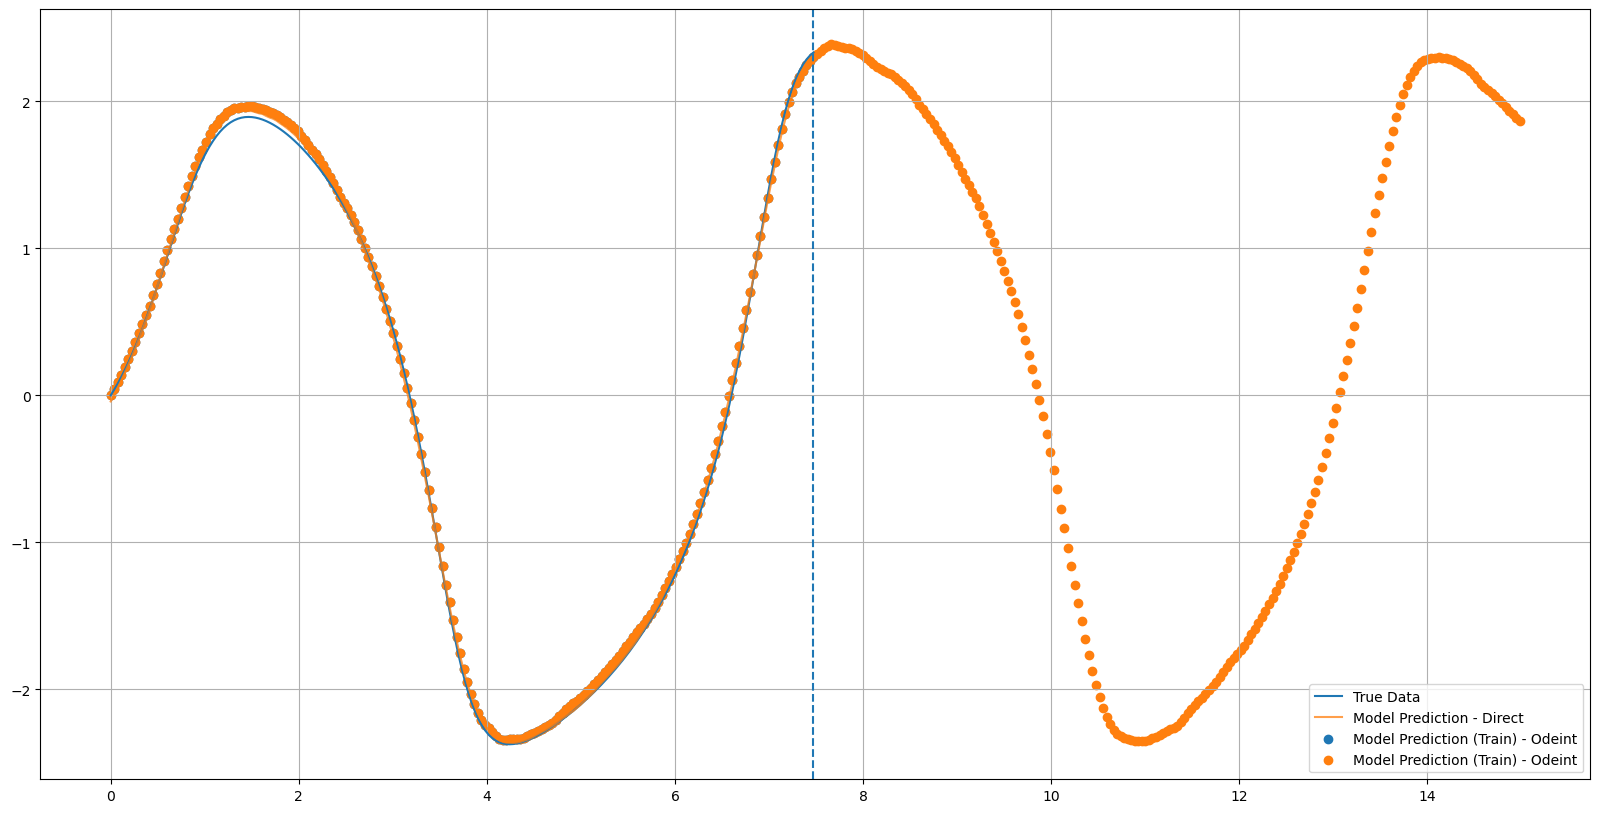

In [16]:
y0 = jnp.array([0.0])
t = jnp.array(t_vdp[L:R])
y_pred = ode_model.neural_ode(y0, t, (Xs, t))

t_test = jnp.array(t_vdp[L:R*2])
Xs_test = y_noisy_vdp[L:R*2, 1]
y_pred_test = ode_model.neural_ode(y0, t_test, (Xs_test, t_test))

print(f"Mean Absolute Error - Direct: {np.mean(np.abs(ys.T - u_model))}")
print(f"Mean Absolute Error - ODE solver: {np.mean(np.abs(ys - y_pred))}")

plt.figure(figsize=(20, 10))
plt.plot(t_vdp[L:R], y_vdp[L:R,0:1], label='True Data', alpha = 1)
# plt.scatter(t_ho_cheb[L:R], y_noisy_ho_cheb[L:R, 0], label='True Data', alpha = 1)

plt.plot(t_vdp[L:R], u_model, label='Model Prediction - Direct', alpha = 0.75)
plt.scatter(t_vdp[L:R], y_pred[:,0], label='Model Prediction (Train) - Odeint')
plt.scatter(t_vdp[L:R*2], y_pred_test, label='Model Prediction (Train) - Odeint')

plt.axvline(x = max(t_vdp[L:R]), ls = '--')
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

---
## ADMM

In [26]:
L, R = 0, 400

ys = np.atleast_2d(y_noisy_vdp[L:R, 0]).T
ts = np.array(t_vdp)[L:R]
Xs = np.atleast_2d(y_noisy_vdp[L:R, 1]).T

import nn_pyomo_cont_admm_2
importlib.reload(nn_pyomo_cont_admm_2)
NeuralODEPyomoADMM = nn_pyomo_cont_admm_2.NeuralODEPyomoADMM

tol = 1e-7
params = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        # "acceptable_tol": 1e-15, "acceptable_constr_viol_tol": 1e-15, "acceptable_dual_inf_tol": 1e-15, "acceptable_compl_inf_tol": 1e-15, "acceptable_iter": 0, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 500}

layer_widths = [2, 20, 1]

ode_model = NeuralODEPyomoADMM(ys, # y
                        ts, # t
                        np.array(None),
                        layer_widths, act_func = "tanh", 
                        # y_init = np.array(estimated_solution_ho), 
                        extra_input = Xs,
                        penalty_lambda_reg = 0.1, 
                        time_invariant = True,
                        # extra_input 
                        w_init_method = 'xavier', 
                        params = params,
                        deriv_method = "pyomo",
                        is_continuous = True
                        )

ode_model.build_model()
result = ode_model.solve_model()

ValueError: A general discretization scheme has already been applied to to every ContinuousSet in the model. If you would like to specify a specific discretization scheme for one of the ContinuousSets you must discretize each ContinuousSet separately.

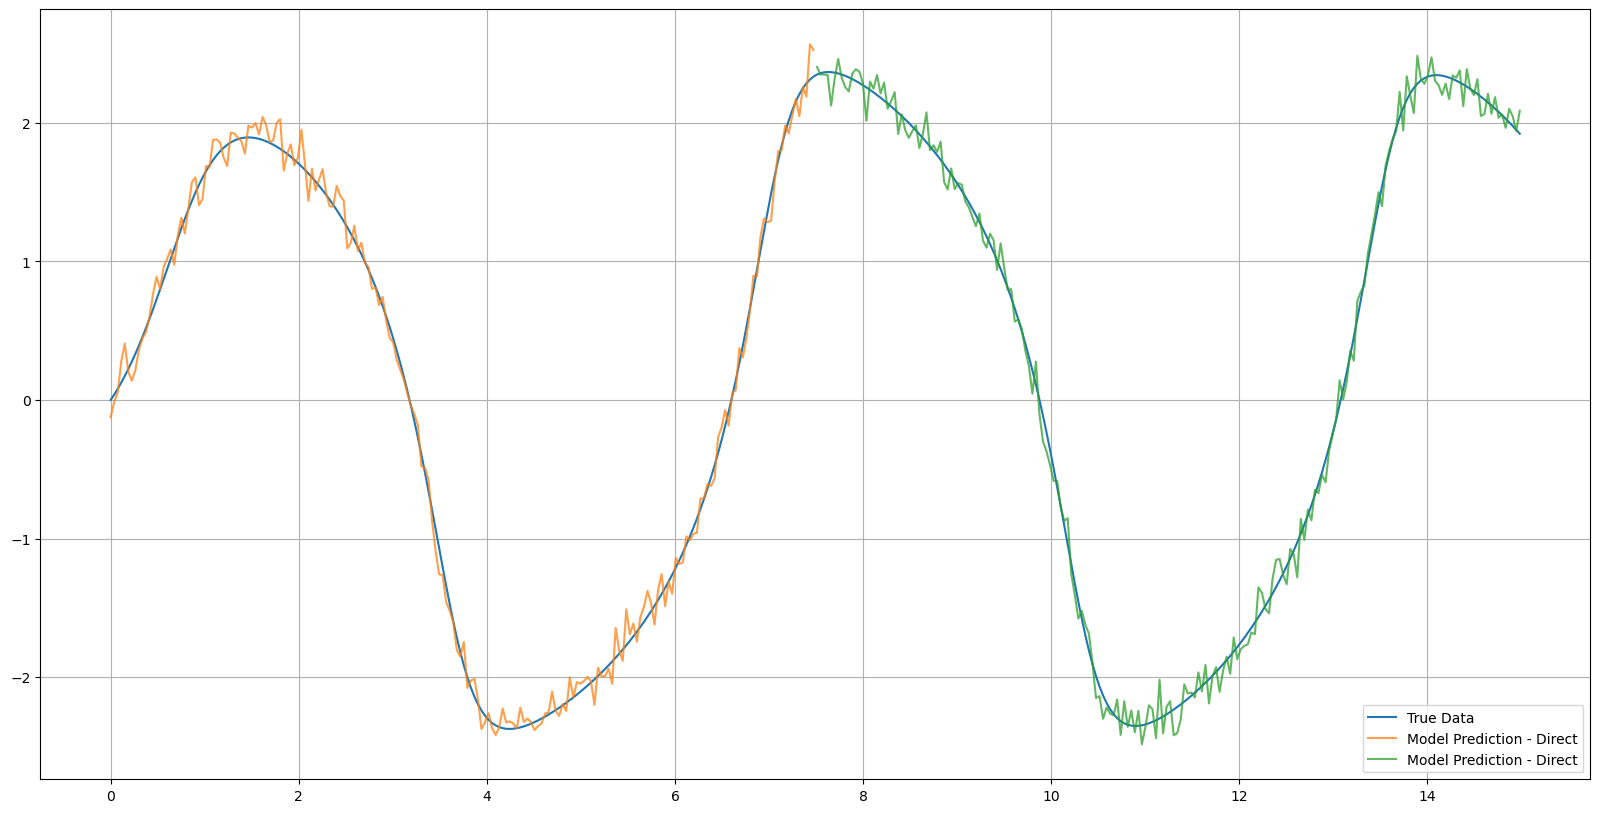

In [27]:
y1, y2 = ode_model.extract_solution()

plt.figure(figsize=(20, 10))
plt.plot(t_vdp[L:R], y_vdp[L:R,0:1], label='True Data', alpha = 1)
# plt.scatter(t_ho_cheb[L:R], y_noisy_ho_cheb[L:R, 0], label='True Data', alpha = 1)
plt.plot(t_vdp[L:R//2], y1, label='Model Prediction - Direct', alpha = 0.75)
plt.plot(t_vdp[R//2:R], y2, label='Model Prediction - Direct', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

* The next step is to pass the neural network through an ODE solver to ensure the learnt weights and biases of a neural network are correct
* But first let's just pass in the existing inputs to ensure the model had been trained correctly
* Let's start by resonstructing the inputs; which in our case are just `y_noisy_vdp`

In [531]:
derivative = []
for row in y_noisy_vdp[L:R//2]:
    derivative.append(ode_model.predict(row))
    
model_derivative = ode_model.extract_derivative()

d1 = [d for (d, _) in derivative]
d2 = [d for (_, d) in derivative]

# Extra: extracting the derivative learnt directly from the model
model_time = [i for (i,_) in model_derivative]
model_derivative = [i for (_,i) in model_derivative]

Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets: 2
Model index is 0
Model index is 1
Number of weight sets:

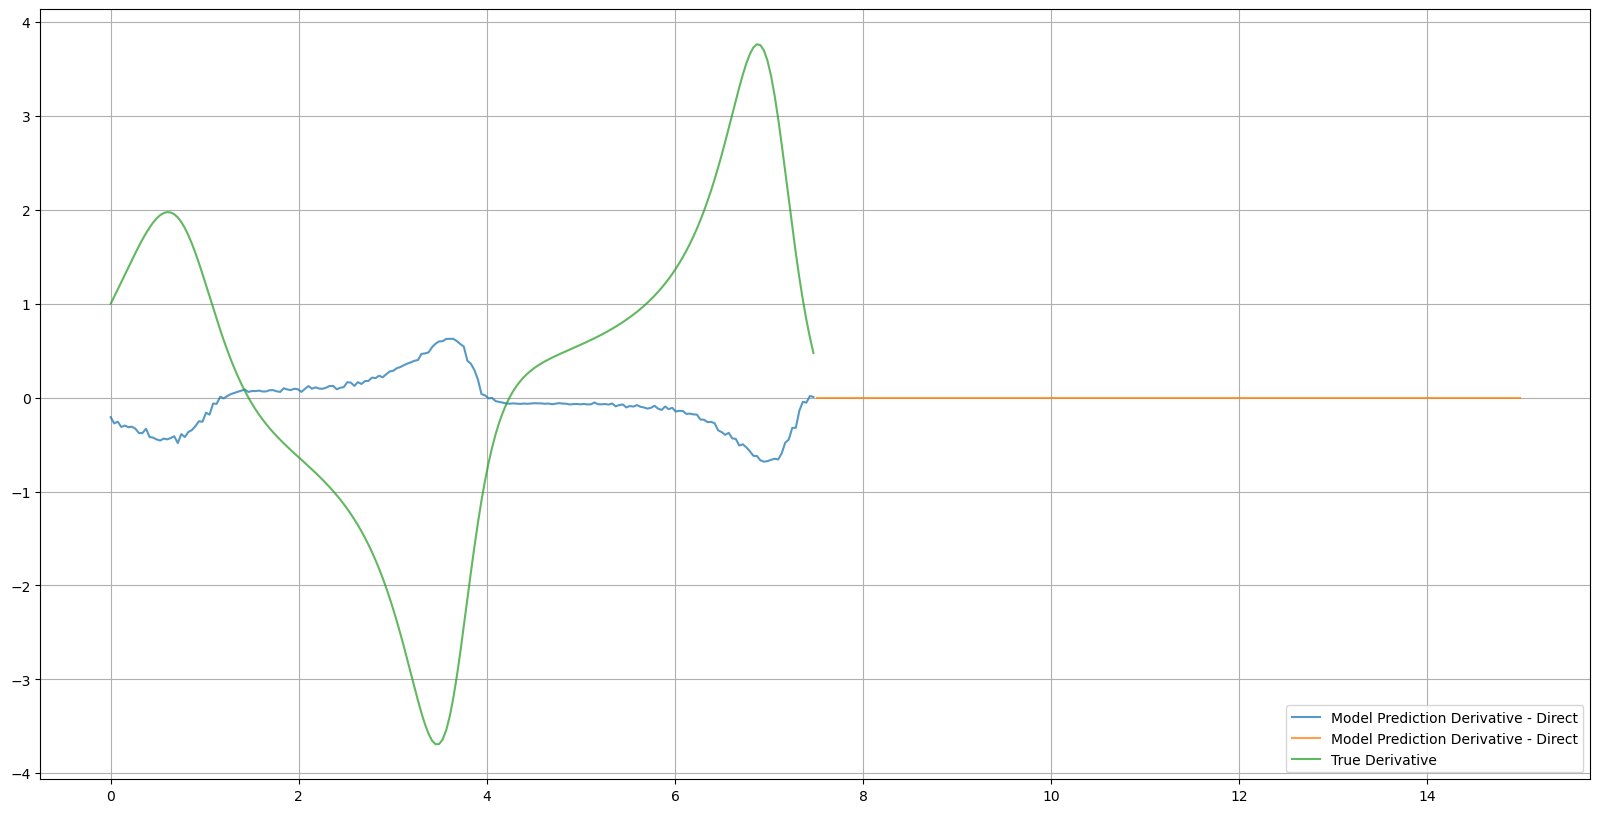

In [532]:
plt.figure(figsize=(20, 10))
plt.plot(t_vdp[L:R//2], d1, label='Model Prediction Derivative - Direct', alpha = 0.75)
plt.plot(t_vdp[R//2:R], d2, label='Model Prediction Derivative - Direct', alpha = 0.75)

plt.plot(t_vdp[L:R//2], true_derivatives_vdp[L:R//2,0], label='True Derivative', alpha = 0.75)

#plt.plot(model_time[0], model_derivative[0], label='True Derivative', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

In [508]:
extra_args = (jnp.array(y_noisy_vdp[L:R, 1]), jnp.array(ts))
y_pred = ode_model.neural_ode(jnp.array(y0), jnp.array(ts[L:R//2]), extra_args = extra_args)

Model index is 0
Model index is 1
Number of weight sets: 2


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape float64[].
This occurred in the item() method of jax.Array
The error occurred while tracing the function _fn at /Users/mariiashapo/anaconda3/envs/collocation_env/lib/python3.9/site-packages/equinox/_eval_shape.py:31 for jit. This concrete value was not available in Python because it depends on the values of the arguments _dynamic[1][1], _dynamic[1][2][0], and _dynamic[1][2][1].

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

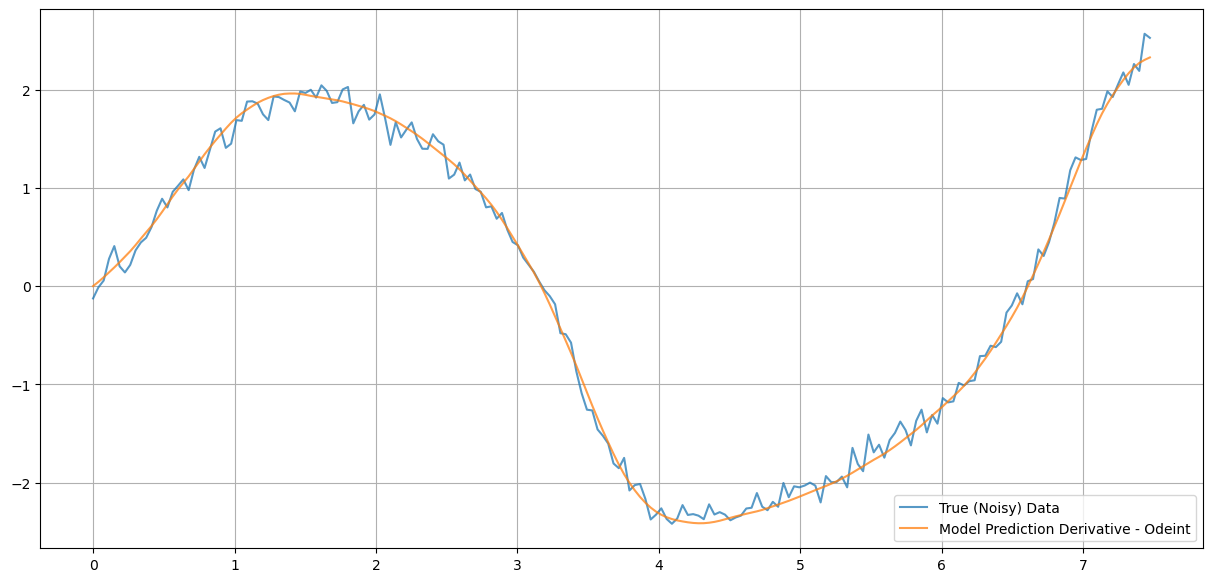

In [424]:
plt.figure(figsize=(15, 7))
plt.plot(ts[L:R//2], y_noisy_vdp[L:R//2, 0], label='True (Noisy) Data', alpha = 0.75)
plt.plot(ts[L:R//2], y_pred, label='Model Prediction Derivative - Odeint', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.show()

### Generate 2 Sets of Data with Chebyshev node spacing


In [34]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
N = 200
noise_level = 0.1
ode_type, params = "van_der_pol", {"mu": 1, "omega": 1}
start_time, end_time = 0, 15
spacing_type = "chebyshev" # "equally_spaced" or "chebyshev"
initial_state = jnp.array([0.0, 1.0])

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp_cheb_1, y_vdp_cheb_1, y_noisy_vdp_cheb_1, true_derivatives_vdp_cheb_1 = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp_cheb_1 = np.array(jnp.squeeze(y_noisy_vdp_cheb_1))
t_vdp_cheb_1 = np.array(jnp.squeeze(t_vdp_cheb_1))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_vdp_cheb_1 = compute_weights(t_vdp_cheb_1)
D_vdp_cheb_1 = np.array(lagrange_derivative(t_vdp_cheb_1, weights_vdp_cheb_1))

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
est_der_vdp_cheb_1, est_sol_vdp_cheb_1 = collocate_data(y_noisy_vdp_cheb_1, t_vdp_cheb_1, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [72]:
#---------------------------------------------DATA PARAMS---------------------------------------------#
# redefine the start time and the initial state
start_time, end_time = 15, 30 
initial_state = y_vdp_cheb[-1]

#--------------------------------------------GENERATE DATA--------------------------------------------#
t_vdp_cheb_2, y_vdp_cheb_2, y_noisy_vdp_cheb_2, true_derivatives_vdp_cheb_2 = generate_ode_data(N, noise_level, ode_type, params, start_time, end_time, spacing_type, initial_state)

# numpy array is required for pyomo
y_noisy_vdp_cheb_2 = np.array(jnp.squeeze(y_noisy_vdp_cheb_2))
t_vdp_cheb_2 = np.array(jnp.squeeze(t_vdp_cheb_2))

#-----------------------------------------COLLOCATION MATRIX PREPARATION-------------------------------------------#
weights_vdp_cheb_2 = compute_weights(t_vdp_cheb_2)
D_vdp_cheb_2 = np.array(lagrange_derivative(t_vdp_cheb_2, weights_vdp_cheb_2))

#--------------------------------------------NON-PARAMETRIC COLLOCATION--------------------------------------------#
est_der_vdp_cheb_2, est_sol_vdp_cheb_2 = collocate_data(y_noisy_vdp_cheb_2, t_vdp_cheb_2, 'EpanechnikovKernel', bandwidth=0.5)

/Users/mariiashapo/Library/CloudStorage/OneDrive-Personal/project_2324/NODE/00_utils/non_parametric_collocation.py:95: UserWarning: Data transposed to match expected dimensions.
  warnings.warn("Data transposed to match expected dimensions.")


In [78]:
ys = np.concatenate([np.atleast_2d(y_noisy_vdp_cheb_1[:, 0]), np.atleast_2d(y_noisy_vdp_cheb_2[:, 0])], axis = 1).T
ts = np.concatenate([t_vdp_cheb_1, t_vdp_cheb_2])
Xs = np.concatenate([np.atleast_2d(y_noisy_vdp_cheb_1[:, 1]), np.atleast_2d(y_noisy_vdp_cheb_2[:, 1])], axis = 1).T
y_est = np.concatenate([est_sol_vdp_cheb_1[0], est_sol_vdp_cheb_2[0]])
Ds = [D_vdp_cheb_1, D_vdp_cheb_2]

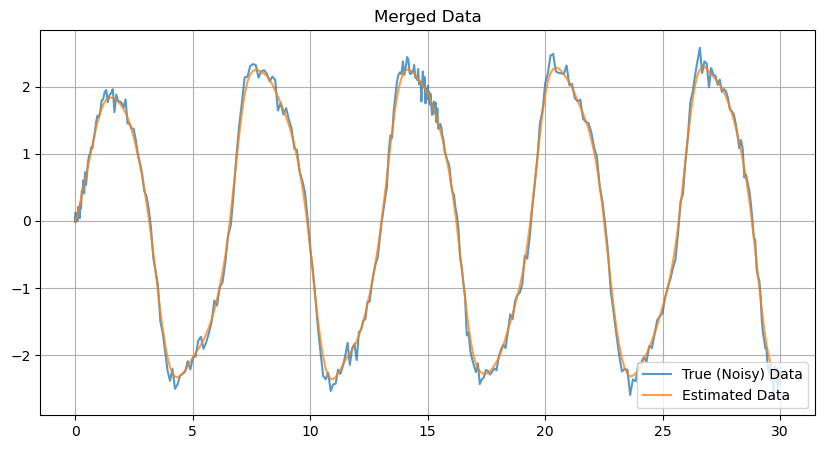

In [123]:
plt.figure(figsize=(10, 5))
plt.plot(ts, ys, label='True (Noisy) Data', alpha = 0.75)
# plt.plot(ts, Xs, label='True (Noisy) Data - aux', alpha = 0.75)
plt.plot(ts, y_est, label='Estimated Data', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

In [237]:
import nn_pyomo_admm
importlib.reload(nn_pyomo_admm)
NeuralODEPyomoADMM = nn_pyomo_admm.NeuralODEPyomoADMM

tol = 1e-7
params = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', "print_level": 1, "max_iter": 500}

layer_sizes = [2, 20, 1]

ode_model = NeuralODEPyomoADMM(y_observed = ys, 
                        t = ts, # t
                        first_derivative_matrix = Ds, # derivative matrix
                        extra_input = Xs, # extra inputs
                        y_init = y_est,
                        layer_sizes = layer_sizes, act_func = "tanh", 
                        penalty_lambda_reg = 0.01, 
                        rho = 10.0,
                        time_invariant = True,
                        w_init_method = 'xavier', 
                        params = params
                        )

ode_model.build_model()
result = ode_model.admm_solve(iterations=100, tol_primal=1e-2, tol_dual = 1e-2)

----------------------------------------------------------------------------------------------------
ADMM Iteration 1/100; 0
----------------------------------------------------------------------------------------------------
Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
halt_on_ampl_error=yes
print_level=1
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Ipopt 3.14.16: tol=1e-07
dual_inf_tol=1e-07
compl_inf_tol=1e-07
constr_viol_tol=1e-07
halt_on_ampl_error=yes
print_level=1
max_iter=500


******************************************************************************
This program contains Ipopt, a li

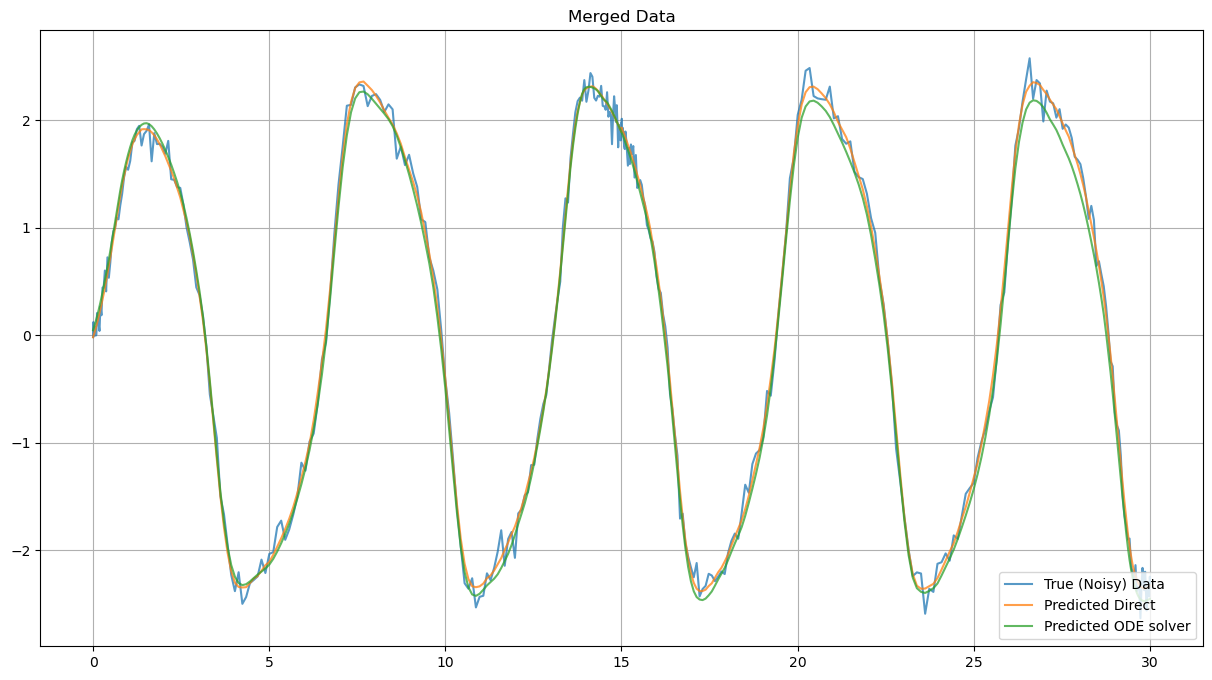

In [236]:
u_model = ode_model.extract_solution().T
y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts), 'both')

plt.figure(figsize=(15, 8))
plt.plot(ts, ys, label='True (Noisy) Data', alpha = 0.75)
#plt.plot(ts, Xs, label='True (Noisy) Data', alpha = 0.75)
plt.plot(ts, u_model, label='Predicted Direct', alpha = 0.75)
plt.plot(ts, y_pred, label='Predicted ODE solver', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

---
# Real Life Data

In [597]:
importlib.reload(preprocessing)
import preprocessing

data_subsample = load_data('../04_energy_consumption_reformat/df_train.csv', '2010-01-10', 350)
data_subsample = add_time_features(data_subsample)
data_subsample = smooth_signal(data_subsample)
data_subsample = create_lags(data_subsample, tau=48, m=2)
train_data, test_data = train_test_split(data_subsample, 250)
train_data_interpolated = interpolate_data(train_data, np.linspace(train_data['t'].min(), train_data['t'].max(), 500), ['y', 'y_lag1', 'y_lag2', 'y_lag3'])
df_train_1, df_train_1 = scale_features(pd.DataFrame(train_data_interpolated), test_data)

FileNotFoundError: [Errno 2] No such file or directory: 'path_to_file.csv'

In [594]:
importlib.reload(preprocessing)
from preprocessing import load_data, preprocess_data 

file_path = '../04_energy_consumption_reformat/df_train.csv'
start_date = '2010-01-10'
number_of_points = 350

# sigma = 1, split = 300, num_nodes_mult = 1, equally_spaced = False
data_subsample = load_data(file_path, start_date, number_of_points)
df_train_1, df_test_1 = preprocess_data(data_subsample, 48, 2, sigma = 0.05)

start_date = '2011-01-10'
data_subsample = load_data(file_path, start_date, number_of_points)
df_train_2, df_test_2 = preprocess_data(data_subsample, 48, 2, sigma = 0.05)

The first/ last time points in the subsample are 2010-01-10 00:00:00/ 2010-01-17 06:30:00
Covering 7 days
Number of points per day: 48
Time offset needed for 1 day: 0.13714285714285715
Training data: 204 timepoints
Training data: 50 timepoints
Training data: 204 timepoints after interpolation
The first/ last time points in the subsample are 2011-01-10 00:00:00/ 2011-01-17 06:30:00
Covering 7 days
Number of points per day: 48
Time offset needed for 1 day: 0.13714285714285715
Training data: 204 timepoints
Training data: 50 timepoints
Training data: 204 timepoints after interpolation


In [509]:
# shift the time
df_train_2['t'] = df_train_2['t'] + max(df_train_2['t']) - min(df_train_2['t'])

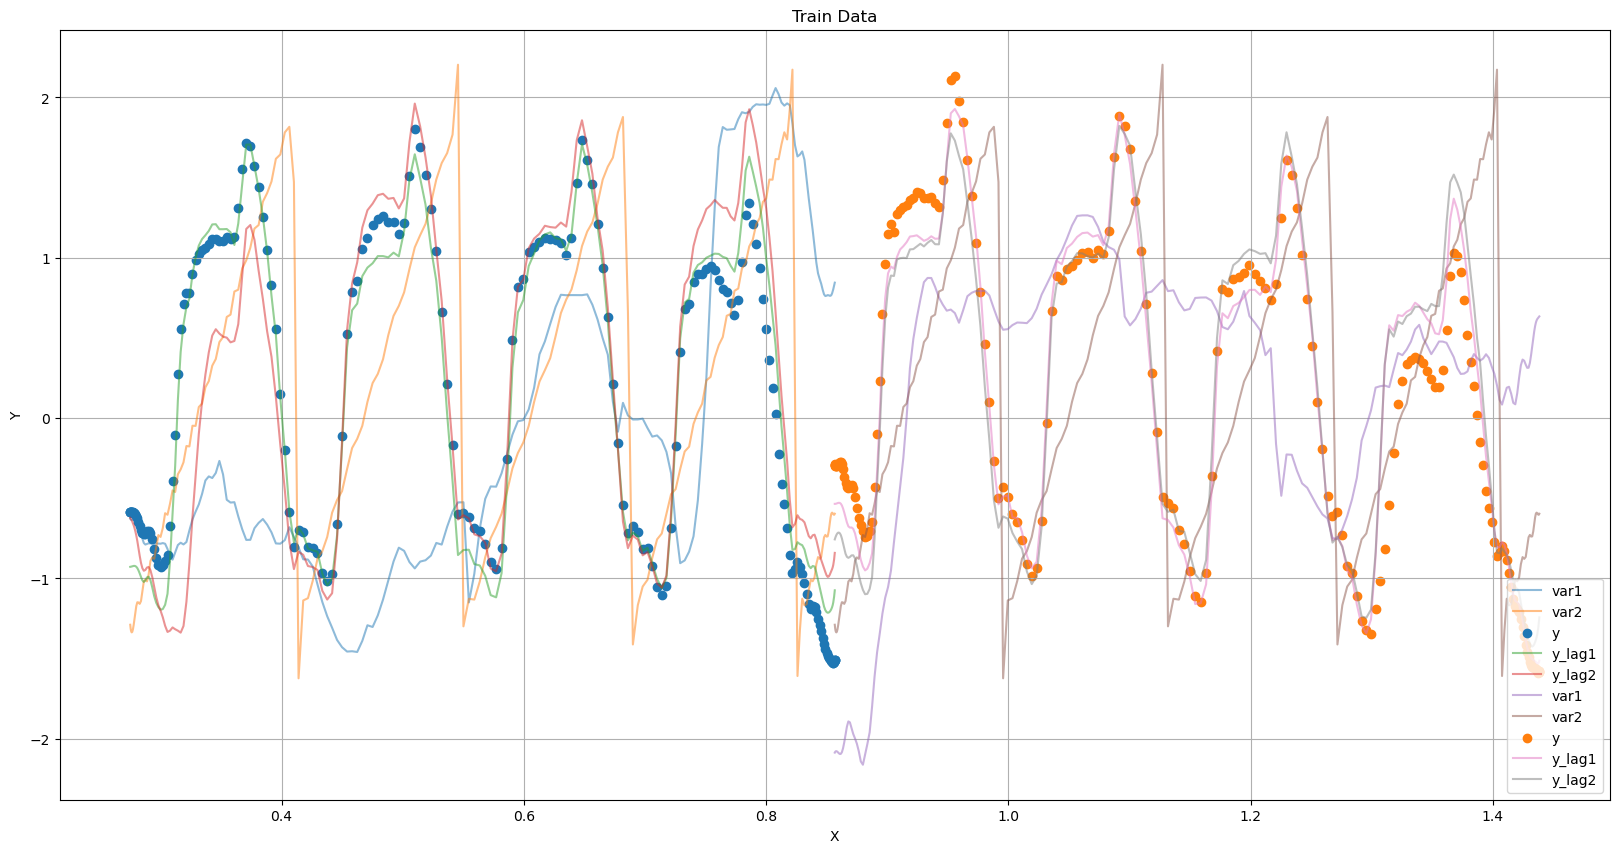

In [510]:
plot = True

if plot:
    plt.figure(figsize=(20, 10))
    for col in df_train_1.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_train_1['t'], df_train_1[col], label=col, alpha=1)
            continue
        plt.plot(df_train_1['t'], df_train_1[col], '-', label=col, alpha=0.5)
    for col in df_train_2.columns.difference(['t']):
        if col == 'y':
            plt.scatter(df_train_2['t'], df_train_2[col], label=col, alpha=1)
            continue
        plt.plot(df_train_2['t'], df_train_2[col], '-', label=col, alpha=0.5)

    plt.legend(loc = "lower right")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Train Data')
    plt.grid(True)
    plt.show()
    

In [583]:
ys = np.concatenate([np.atleast_2d(df_train_1['y']), np.atleast_2d(df_train_2['y'])], axis = 1).T
ts = np.concatenate([df_train_1['t'], df_train_2['t']])
Xs = np.concatenate([np.atleast_2d(df_train_1.drop(columns=['y', 't'])).T, np.atleast_2d(df_train_2.drop(columns=['y', 't'])).T], axis = 1).T

weights_1 = compute_weights(df_train_1['t'])
D_1 = np.array(lagrange_derivative(df_train_1['t'], weights_1))

weights_2 = compute_weights(df_train_2['t'])
D_2 = np.array(lagrange_derivative(df_train_2['t'], weights_2))

Ds = [D_1, D_2]

In [585]:
import nn_pyomo_admm
importlib.reload(nn_pyomo_admm)
NeuralODEPyomoADMM = nn_pyomo_admm.NeuralODEPyomoADMM

tol = 1e-8
params = {"tol":tol, 
        "dual_inf_tol": tol, "compl_inf_tol": tol, "constr_viol_tol": tol, 
        "halt_on_ampl_error" : 'yes', "print_level": 5, "max_iter": 500}

layer_sizes = [5, 20, 1]

ode_model = NeuralODEPyomoADMM(y_observed = ys, 
                        t = ts, # t
                        first_derivative_matrix = Ds, # derivative matrix
                        extra_input = Xs, # extra inputs
                        y_init = ys,
                        layer_sizes = layer_sizes, act_func = "tanh", 
                        penalty_lambda_reg = 0.01, 
                        rho = 1.0,
                        time_invariant = True,
                        w_init_method = 'xavier', 
                        params = params
                        )

ode_model.build_model()
result = ode_model.admm_solve(iterations=100, tol_primal=1e-1)

----------------------------------------------------------------------------------------------------
ADMM Iteration 1/100; 0
----------------------------------------------------------------------------------------------------
Ipopt 3.14.16: tol=1e-08
dual_inf_tol=1e-08
compl_inf_tol=1e-08
constr_viol_tol=1e-08
halt_on_ampl_error=yes
print_level=5
max_iter=500


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.1.

Number of nonzeros in equality constraint Jacobian...:    70035
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian..........

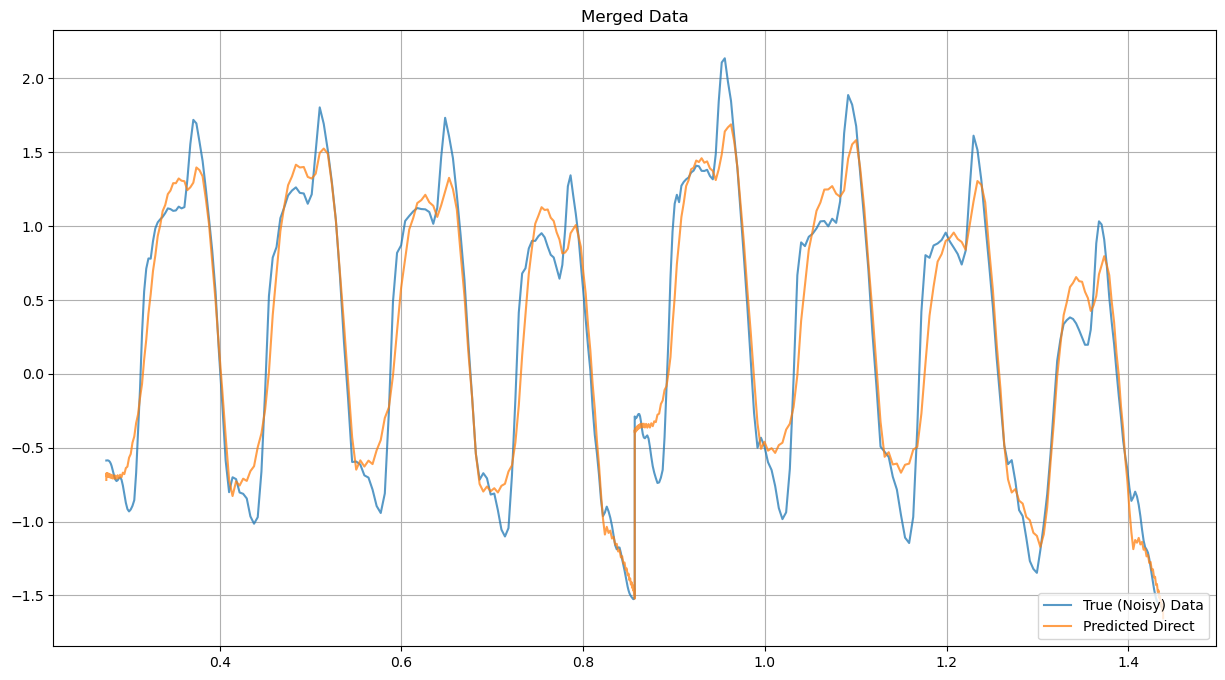

In [586]:
u_model = ode_model.extract_solution().T
y0 = ys[0]
y_pred = ode_model.neural_ode(y0, ts, (Xs, ts/2), 'both')

plt.figure(figsize=(15, 8))
plt.plot(ts, ys, label='True (Noisy) Data', alpha = 0.75)
#plt.plot(ts, Xs, label='True (Noisy) Data', alpha = 0.75)
plt.plot(ts, u_model, label='Predicted Direct', alpha = 0.75)
#plt.plot(ts, y_pred, label='Predicted ODE solver', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

## Check the derivatives learnt

In [587]:
model_derivative = ode_model.extract_derivative()
combined_derivative = np.concatenate([model_derivative[0][1:], model_derivative[1][1:]])

#### Reconstruct predictions from the existing inputs


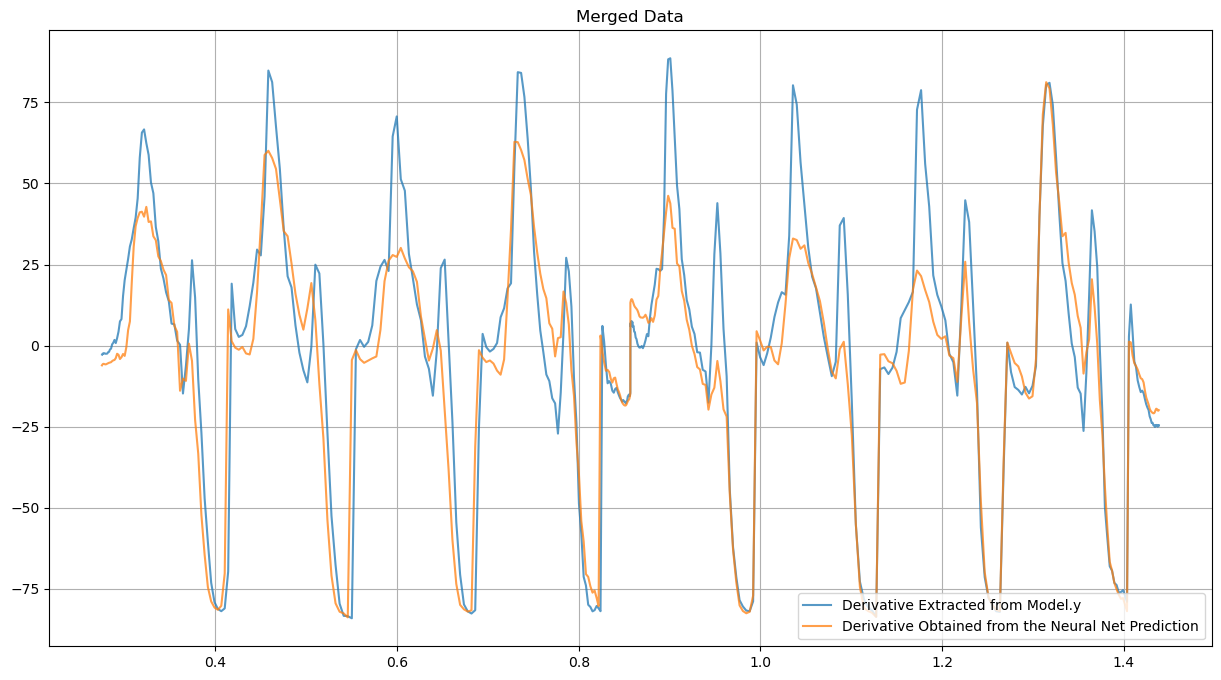

In [589]:
df_train = pd.concat([df_train_1, df_train_2])
df_train.sort_values('t', inplace=True)
df_train = df_train.drop(columns='t')
df_train.reset_index(drop=True, inplace=True)

# arrange columns in the expected order
temp_column = df_train['y']
df_train = df_train.drop(['y'], axis=1)
df_train.insert(loc=0, column='y', value=temp_column)

derivative = []
for index in range(len(df_train)):
    derivative.append(ode_model.predict(jnp.array(df_train.loc[index]), weights = 'consensus'))

d1 = [d.item() for d in derivative]

plt.figure(figsize=(15, 8))
plt.plot(ts[2:], combined_derivative, label='Derivative Extracted from Model.y',alpha = 0.75)
plt.plot(ts, d1, label='Derivative Obtained from the Neural Net Prediction',alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

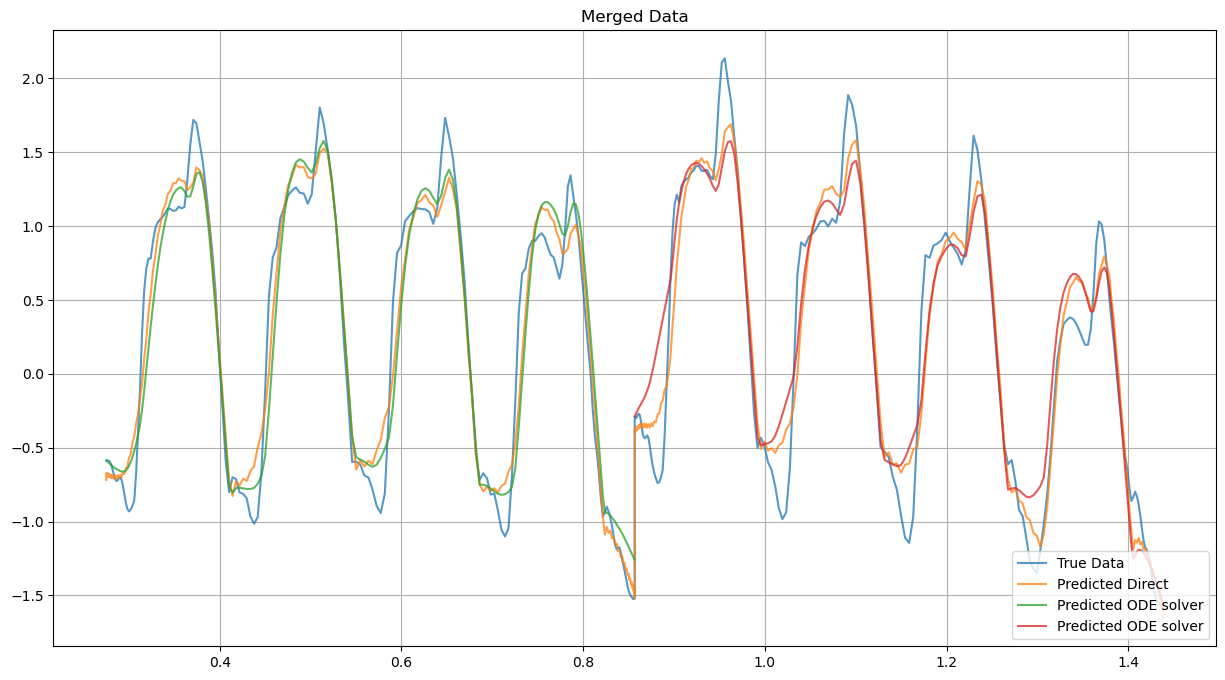

In [590]:
importlib.reload(nn_pyomo_admm)
ode_model.neural_ode = nn_pyomo_admm.NeuralODEPyomoADMM.neural_ode.__get__(ode_model)

M = len(ts)//2

u_model = ode_model.extract_solution().T
y0 = ys[0]
y_pred1 = ode_model.neural_ode(y0, ts[:M], (Xs[:M], ts[:M]), 'consensus')

y0 = ys[M]
y_pred2 = ode_model.neural_ode(y0, ts[M:], (Xs[M:], ts[M:]), 'consensus')

plt.figure(figsize=(15, 8))
plt.plot(ts, ys, label='True Data', alpha = 0.75)
plt.plot(ts, u_model, label='Predicted Direct', alpha = 0.75)
plt.plot(ts[:M], y_pred1, label='Predicted ODE solver', alpha = 0.75)
plt.plot(ts[M:], y_pred2, label='Predicted ODE solver', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

---

### Will this work on the test set?

In [591]:
ys = np.concatenate([np.atleast_2d(df_train_1['y']), np.atleast_2d(df_train_2['y'])], axis = 1).T
ts = np.concatenate([df_train_1['t'], df_train_2['t']])
Xs = np.concatenate([np.atleast_2d(df_train_1.drop(columns=['y', 't'])).T, np.atleast_2d(df_train_2.drop(columns=['y', 't'])).T], axis = 1).T

In [592]:
importlib.reload(nn_pyomo_admm)
ode_model.neural_ode = nn_pyomo_admm.NeuralODEPyomoADMM.neural_ode.__get__(ode_model)

df_test_1.reset_index(drop=True, inplace=True)
ts_1_test = jnp.array(df_test_1['t'])
Xs_1_test = jnp.array(df_test_1.drop(columns=['y', 't']))
y0 = jnp.array([df_test_1['y'][0]])
y_pred1_test = ode_model.neural_ode(y0, ts_1_test[:-2], (Xs_1_test[:-2], ts_1_test[:-2]), 'consensus')

df_test_2.reset_index(drop=True, inplace=True)
ts_2_test = jnp.array(df_test_2['t'])
Xs_2_test = jnp.array(df_test_2.drop(columns=['y', 't']))
y0 = jnp.array([df_test_2['y'][0]])
y_pred_2_test = ode_model.neural_ode(y0, ts_2_test[:-2], (Xs_2_test[:-2], ts_2_test[:-2]), 'consensus')

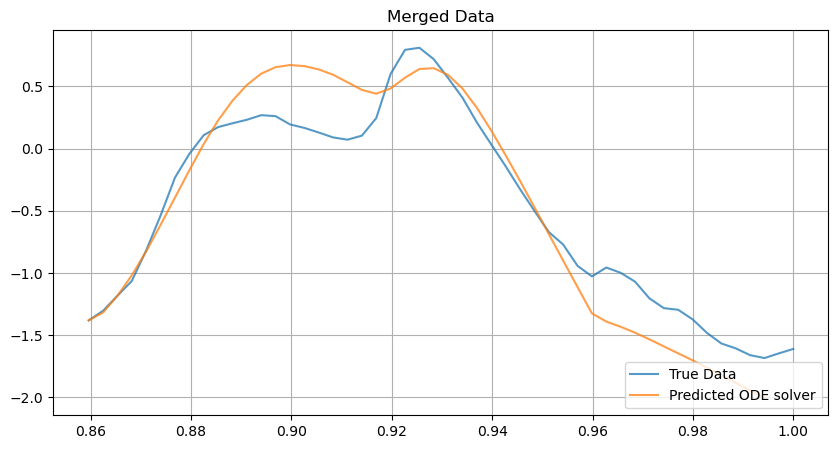

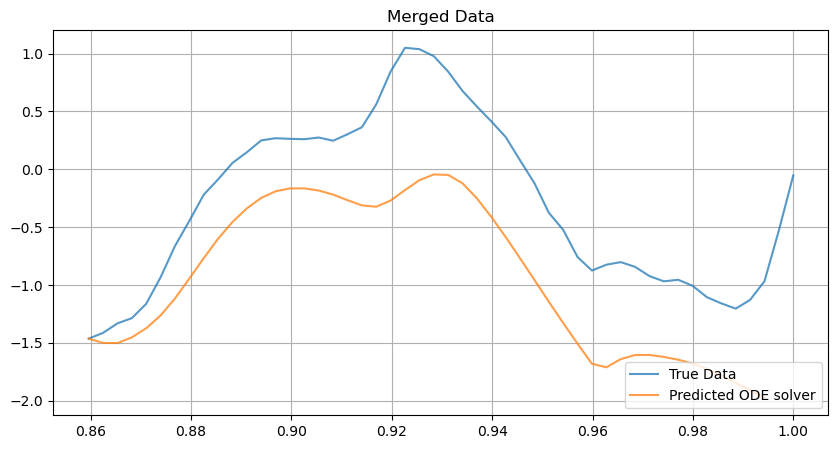

In [593]:
plt.figure(figsize=(10, 5))
plt.plot(ts_1_test, df_test_1['y'], label='True Data', alpha = 0.75)
plt.plot(ts_1_test[:-2], y_pred1_test, label='Predicted ODE solver', alpha = 0.75)

plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(ts_2_test, df_test_2['y'], label='True Data', alpha = 0.75)
plt.plot(ts_2_test[:-2], y_pred_2_test, label='Predicted ODE solver', alpha = 0.75)
plt.legend(loc ="lower right")
plt.grid(True)
plt.title("Merged Data")
plt.show()